In [2]:
# Librerías básicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import math
from math import sqrt

import seaborn as sns
sns.set()

In [3]:
# Librerías de sklearn y keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
scaler = MinMaxScaler()

# El módulo Statsmodels

Statsmodels es un módulo de Python que ofrece clases y funciones de varios modelos estadísticos, así como pruebas de hipótesis 
y análisis exploratorio de datos. La documentación se encuentra en <a href='https://www.statsmodels.org/stable/index.html'>statsmodels.org</a>. 

In [6]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.graphics.tsaplots as sgt
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 

# Fuentes de datos interesantes

## API de Yahoo finance

Yahoo Finance tiene una API que permite descargar información financiera para realizar análisis. La página web original de la documentación ya no existe. Sin embargo, existen algunas páginas de documentación no oficial como <a href= 'https://github.com/mxbi/yahoo-finance-api.git'> este repositorio en GitHub, </a> o <a href='https://python-yahoofinance.readthedocs.io/en/latest/api.html'> esta página de documentación the ReadTheDocs </a>.

In [9]:
# Instalación de yfinance
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Se importa la librería yfinance
import yfinance

In [11]:
# Se descargan los datos S&P500 y Nikkei225
df_yfinance_raw = yfinance.download(tickers = "^GSPC ^N225", #Las series de tiempo de interés - (en nuestro caso, S&P500 y NIKKEI225)
                              start = "1994-01-07", #Fecha inicial
                              end = "2024-08-27", #Fecha final
                              interval = "1d", #Frecuencia.
                              group_by = 'ticker', #Criterio de agrupación. Usualmente "ticker"
                              auto_adjust = True#,  
                              #threads = True
                               ) #. 

[*********************100%***********************]  2 of 2 completed


In [12]:
df_yfinance_raw.head()

Ticker           ^GSPC                                                   \
Price             Open        High         Low       Close       Volume   
Date                                                                      
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0   
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0   
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0   
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0   
1994-01-13  474.170013  474.170013  471.799988  472.470001  277970000.0   

Ticker             ^N225                                                   
Price               Open          High           Low         Close Volume  
Date                                                                       
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766    0.0  
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453    0.0  
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000    0.0  
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859    0.0  
1994-01-13  18770.380859  18823.380859  18548.750000  18577.259766    0.0

In [13]:
# Se crea una copia para modificar
df_yfinance = df_yfinance_raw.copy()

In [14]:
# Se agregan columnas para el nivel de cierre de los índices S&P500 y Nikkei255
df_yfinance['spx'] = df_yfinance['^GSPC'].Close
df_yfinance['nikkei'] = df_yfinance['^N225'].Close

In [15]:
#f_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_yfinance['^N225'] # Se retiran los grupos de columnas '^N225' y '^GSPC'
del df_yfinance['^GSPC']
df_yfinance=df_yfinance.asfreq('b') # Se establece la frecuencia de los datos
df_yfinance=df_yfinance.fillna(method='ffill') # Se rellenan los datos faltantes con el método ffill que usa el último valor válido

In [16]:
df_yfinance.head()

Ticker,spx,nikkei
Price,,
Date,,
1994-01-07,469.899994,18124.009766
1994-01-10,475.269989,18443.439453
1994-01-11,474.130005,18485.250000
1994-01-12,474.170013,18793.880859
1994-01-13,472.470001,18577.259766


In [17]:
df_yfinance.columns

MultiIndex([(   'spx', ''),
            ('nikkei', '')],
           names=['Ticker', 'Price'])

In [18]:
df_yfinance.columns=['spx','nikkei']

In [19]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [20]:
df_yfinance.head() 

,spx,nikkei
Date,,
1994-01-07,469.899994,18124.009766
1994-01-10,475.269989,18443.439453
1994-01-11,474.130005,18485.250000
1994-01-12,474.170013,18793.880859
1994-01-13,472.470001,18577.259766


In [21]:
df_yfinance.columns

Index(['spx', 'nikkei'], dtype='object')

In [22]:
df_yfinance.index = pd.to_datetime(df_yfinance.index)

In [23]:
df_yfinance.tail() # Making sure of the last day we're including in the series

,spx,nikkei
Date,,
2024-08-20,5597.120117,38062.921875
2024-08-21,5620.850098,37951.800781
2024-08-22,5570.640137,38211.011719
2024-08-23,5634.609863,38364.269531
2024-08-26,5616.839844,38110.218750


In [24]:
#df_comp.date = pd.to_datetime(df_comp.date, dayfirst = True)
#df_comp.set_index("date", inplace=True)
df_yfinance=df_yfinance.asfreq('b')
df_yfinance=df_yfinance.fillna(method='ffill')

In [25]:
df_yfinance.head()

,spx,nikkei
Date,,
1994-01-07,469.899994,18124.009766
1994-01-10,475.269989,18443.439453
1994-01-11,474.130005,18485.250000
1994-01-12,474.170013,18793.880859
1994-01-13,472.470001,18577.259766


In [26]:
df_yfinance.index = pd.to_datetime(df_yfinance.index).tz_localize(None)

## Algunos archivos csv con datos

En <a href='https://github.com/jbrownlee/Datasets.git'>este repositorio de GitHub</a> se encuentran muchos archivos .csv con datos apropiados para ejercicios de aprendizaje de máquina y series de tiempo. En este notebook utilizaremos el archivo 'airline_passengers.csv'.

In [28]:
df_airline = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [29]:
df_airline.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [30]:
df_airline.index = pd.to_datetime(df_airline.index)

## Datos que vienen con la librería statsmodels
La librería <a href='https://www.statsmodels.org/stable/index.html'>statsmodels</a> tiene varios conjuntos de datos incorporados.
En este notebook, utilizaremos el dataset 'macrodata', que trae datos macroeconómicos de EEUU.

In [32]:
#import pandas as pd
import statsmodels.api as sm
df_macrodata = sm.datasets.macrodata.load_pandas().data
df_macrodata.index = pd.Index(sm.tsa.datetools.dates_from_range('1959Q1', '2009Q3'))
print(sm.datasets.macrodata.NOTE)

::
    Number of Observations - 203

    Number of Variables - 14

    Variable name definitions::

        year      - 1959q1 - 2009q3
        quarter   - 1-4
        realgdp   - Real gross domestic product (Bil. of chained 2005 US$,
                    seasonally adjusted annual rate)
        realcons  - Real personal consumption expenditures (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realinv   - Real gross private domestic investment (Bil. of chained
                    2005 US$, seasonally adjusted annual rate)
        realgovt  - Real federal consumption expenditures & gross investment
                    (Bil. of chained 2005 US$, seasonally adjusted annual rate)
        realdpi   - Real private disposable income (Bil. of chained 2005
                    US$, seasonally adjusted annual rate)
        cpi       - End of the quarter consumer price index for all urban
                    consumers: all items (1982-84 = 100, seasonally adju

In [33]:
df_macrodata.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-03-31,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-06-30,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-09-30,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-12-31,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-03-31,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [34]:
df_macrodata.index = pd.to_datetime(df_macrodata.index)

## Datos de simulados de ventas

In [36]:
df_ventas = pd.read_excel('Datos_clase_1.xlsx',index_col = 'Fecha', parse_dates = True)

In [37]:
df_ventas.index = pd.to_datetime(df_ventas.index)

# Yahoo finance

## Análisis ETS

In [40]:
yfinance_ets = seasonal_decompose(df_yfinance['spx'])

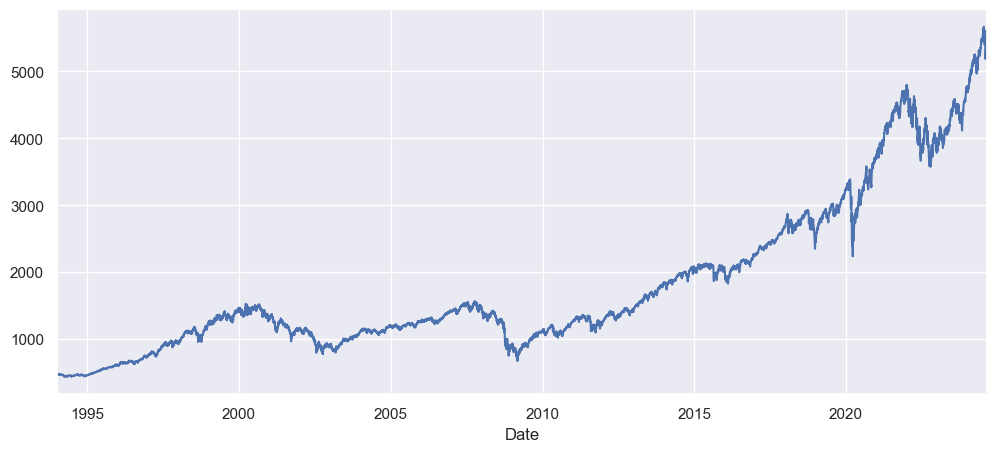

In [41]:
yfinance_ets.observed.plot(figsize=(12,5));

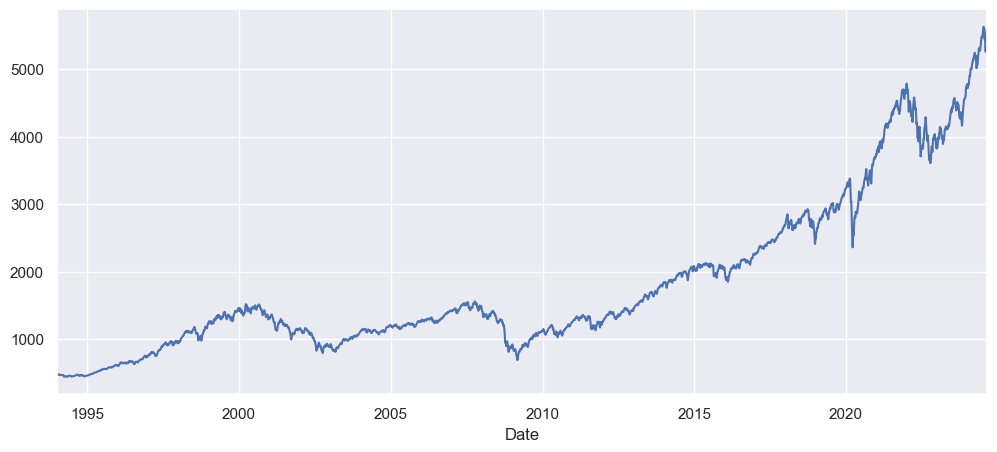

In [42]:
yfinance_ets.trend.plot(figsize=(12,5));

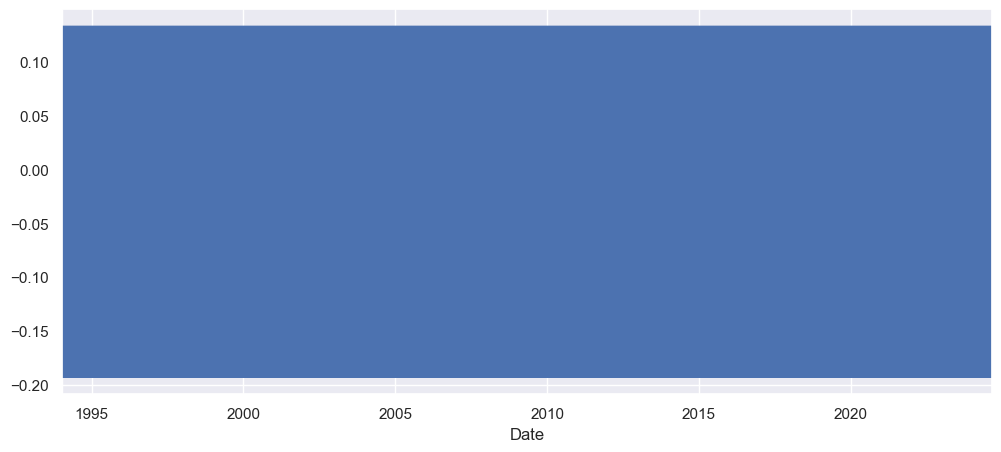

In [43]:
yfinance_ets.seasonal.plot(figsize=(12,5));

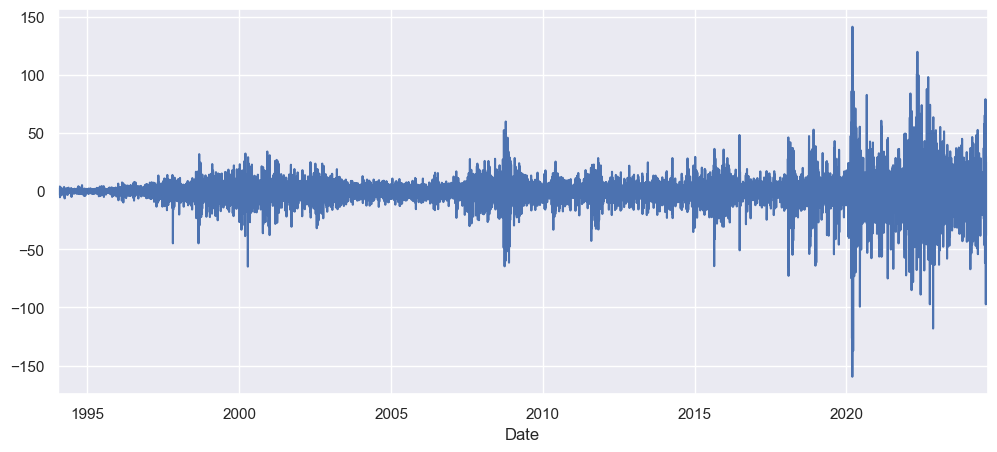

In [44]:
yfinance_ets.resid.plot(figsize=(12,5));

## Train test split

In [46]:
len(df_yfinance)*0.95

7592.4

In [47]:
del df_yfinance['nikkei']

In [48]:
df_yfinance_train = df_yfinance.iloc[:6394]
df_yfinance_test = df_yfinance.iloc[6394:]

In [49]:
df_yfinance_train.head()

,spx
Date,
1994-01-07,469.899994
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013
1994-01-13,472.470001


## Escalamiento de los datos

In [51]:
# Se ajusta el escalador con los datos de entrenamiento
scaler.fit(df_yfinance_train)

MinMaxScaler()

In [52]:
df_yfinance_scaled_train = scaler.transform(df_yfinance_train)
df_yfinance_scaled_test = scaler.transform(df_yfinance_test)

In [53]:
df_yfinance_scaled_train[:5]

array([[0.01272827],
       [0.01493456],
       [0.01446619],
       [0.01448263],
       [0.01378417]])

## Generador de Series de tiempo

In [55]:
# Se importa el generador de series de Keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [56]:
# Se define el generador
n_input = 1
n_features = 1
yfinance_generator = TimeseriesGenerator(df_yfinance_scaled_train, df_yfinance_scaled_train, length=n_input, batch_size=1)

In [57]:
# Aspecto del generador
X,y = yfinance_generator[0]

In [58]:
X,y

(array([[[0.01272827]]]), array([[0.01493456]]))

In [59]:
X.flatten()

array([0.01272827])

In [60]:
y

array([[0.01493456]])

## Creación del modelo

In [62]:
# Definición del modelo
yfinance_model = Sequential()
yfinance_model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
yfinance_model.add(Dense(1))
yfinance_model.compile(optimizer = 'adam', loss='mse')

In [63]:
yfinance_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Ajuste del modelo
yfinance_model.fit_generator(yfinance_generator,epochs=50)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1016\785803347.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  yfinance_model.fit_generator(yfinance_generator,epochs=50)


Epoch 1/50
6393/6393 [==============================] - 49s 7ms/step - loss: 0.0035
Epoch 2/50
6393/6393 [==============================] - 50s 8ms/step - loss: 5.7116e-05
Epoch 3/50
6393/6393 [==============================] - 47s 7ms/step - loss: 5.5141e-05
Epoch 4/50
6393/6393 [==============================] - 40s 6ms/step - loss: 5.5166e-05
Epoch 5/50
6393/6393 [==============================] - 30s 5ms/step - loss: 5.2727e-05
Epoch 6/50
6393/6393 [==============================] - 40s 6ms/step - loss: 5.2781e-05
Epoch 7/50
6393/6393 [==============================] - 34s 5ms/step - loss: 5.1356e-05
Epoch 8/50
6393/6393 [==============================] - 52s 8ms/step - loss: 5.2330e-05
Epoch 9/50
6393/6393 [==============================] - 33s 5ms/step - loss: 5.3097e-05
Epoch 10/50
6393/6393 [==============================] - 38s 6ms/step - loss: 5.1083e-05
Epoch 11/50
6393/6393 [==============================] - 34s 5ms/step - loss: 5.3081e-05
Epoch 12/50
6393/6393 [===========

In [ ]:
plt.plot(range(len(yfinance_model.history.history['loss'])),yfinance_model.history.history['loss']);

## Evaluación del modelo

In [ ]:
yfinance_first_eval_batch = df_yfinance_scaled_train[-1:]

In [ ]:
yfinance_first_eval_batch

In [ ]:
yfinance_first_eval_batch = yfinance_first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
yfinance_model.predict(yfinance_first_eval_batch)

In [ ]:
df_yfinance_scaled_test[0]

In [ ]:
yfinance_test_predictions = []

yfinance_first_eval_batch = df_yfinance_scaled_train[-n_input:]
yfinance_current_batch = yfinance_first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
yfinance_current_batch.shape

In [ ]:
yfinance_test_predictions = []

yfinance_first_eval_batch = df_yfinance_scaled_train[-n_input:]
yfinance_current_batch = yfinance_first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_yfinance_test)):
    
    # Se obtiene la predicción 1 paso hacia adelante
    yfinance_current_pred = yfinance_model.predict(yfinance_current_batch)[0]
    
    # Se guarda la predicción
    yfinance_test_predictions.append(yfinance_current_pred) 
    
    # Se actualiza el lote
    yfinance_current_batch = np.append(yfinance_current_batch[:,1:,:],[[yfinance_current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


In [ ]:
yfinance_test_predictions[:10]

In [ ]:
df_yfinance_scaled_test[:10]

## Transformación inversa y comparación

In [ ]:
yfinance_true_predictions = scaler.inverse_transform(yfinance_test_predictions)

In [ ]:
yfinance_true_predictions[:10]

In [ ]:
df_yfinance_test[:10]

In [ ]:
df_yfinance_test['Predictions'] = yfinance_true_predictions

In [ ]:
df_yfinance_test.head()

In [ ]:
df_yfinance_test.plot(figsize=(12,5));

# Vuelos

## Análisis ETS

In [ ]:
airline_ets = seasonal_decompose(df_airline['Passengers'])

In [ ]:
airline_ets.observed.plot(figsize=(12,5));

In [ ]:
airline_ets.trend.plot(figsize=(12,5));

In [ ]:
airline_ets.seasonal.plot(figsize=(12,5));

In [ ]:
airline_ets.resid.plot(figsize=(12,5));

## Train test split

In [ ]:
airline_train_size = math.ceil(len(df_airline)*0.8)

In [ ]:
airline_train_size

In [ ]:
df_airline_train = df_airline.iloc[:airline_train_size]
df_airline_test = df_airline.iloc[airline_train_size:]

In [ ]:
df_airline_train.head()

## Escalamiento de los datos

In [ ]:
# Se ajusta el escalador con los datos de entrenamiento
scaler.fit(df_airline_train)

In [ ]:
df_airline_scaled_train = scaler.transform(df_airline_train)
df_airline_scaled_test = scaler.transform(df_airline_test)

In [ ]:
df_airline_scaled_train[:5]

## Generador de Series de tiempo

In [ ]:
# Se define el generador
n_input = 12
n_features = 1
airline_generator = TimeseriesGenerator(df_airline_scaled_train, df_airline_scaled_train, length=n_input, batch_size=1)

In [ ]:
# Aspecto del generador
X,y = airline_generator[0]

In [ ]:
X,y

In [ ]:
X.flatten()

In [ ]:
y

## Creación del modelo

In [ ]:
# Definición del modelo
airline_model = Sequential()
airline_model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
airline_model.add(Dense(1))
airline_model.compile(optimizer = 'adam', loss='mse')

In [ ]:
airline_model.summary()

In [ ]:
# Ajuste del modelo
airline_model.fit_generator(airline_generator,epochs=50)

In [ ]:
plt.plot(range(len(airline_model.history.history['loss'])),airline_model.history.history['loss']);

## Evaluación del modelo

In [ ]:
airline_first_eval_batch = df_airline_scaled_train[-12:]

In [ ]:
airline_first_eval_batch

In [ ]:
airline_first_eval_batch = airline_first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
airline_model.predict(airline_first_eval_batch)

In [ ]:
df_airline_scaled_test[0]

In [ ]:
airline_test_predictions = []

airline_first_eval_batch = df_airline_scaled_train[-n_input:]
airline_current_batch = airline_first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
airline_current_batch.shape

In [ ]:
airline_test_predictions = []

airline_first_eval_batch = df_airline_scaled_train[-n_input:]
airline_current_batch = airline_first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(df_airline_test)):
    
    # Se obtiene la predicción 1 paso hacia adelante
    airline_current_pred = airline_model.predict(airline_current_batch)[0]
    
    # Se guarda la predicción
    airline_test_predictions.append(airline_current_pred) 
    
    # Se actualiza el lote
    airline_current_batch = np.append(airline_current_batch[:,1:,:],[[airline_current_pred]],axis=1)

In [ ]:
airline_test_predictions[:10]

In [ ]:
df_airline_scaled_test[:10]

## Transformación inversa y comparación

In [ ]:
airline_true_predictions = scaler.inverse_transform(airline_test_predictions)

In [ ]:
airline_true_predictions[:10]

In [ ]:
df_airline_test[:10]

In [ ]:
df_airline_test['Predictions'] = airline_true_predictions

In [ ]:
df_airline_test.head()

In [ ]:
df_airline_test.plot(figsize=(12,5));

In [ ]:
mean_squared_error(df_airline_test['Passengers'],df_airline_test['Predictions'])

# Datos de ventas

# Datos macroeconómicos de EEUU: PBI real

# Datos macroeconómicos de EEUU: Inflación